In [1]:
%run -i "loaddata.py"
plt.style.use('seaborn-white')
plt.style.use('seaborn-ticks')
plt.rcParams["font.size"] = 13
import scipy.stats as st
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
import xgboost as xgb

What is your name? [Simone/Jonathan/Marcus/Runi]Jonathan


In [2]:
# Choose wisely
save = True
only_2_features=False
test_on = 4

In [3]:
# Collect all data into 1 array
keys = tuple(data_dict.keys())[::2]

data = []
for key in keys:
    for vec in list(data_dict[key]):
        if not np.isnan(vec[0]) and (vec[:][3:]!=0).any():
            data.append(vec)
data = np.array(data)
print(data.shape)
features = data_dict[ list(data_dict.keys())[1] ]

(1568, 28)


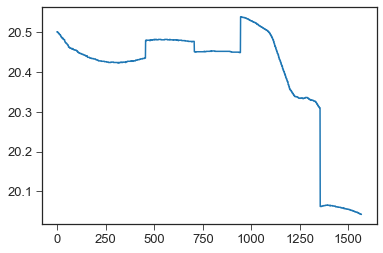

In [4]:
features[8], features[14]
plt.plot(data[:,8])

# All time series in a single plot

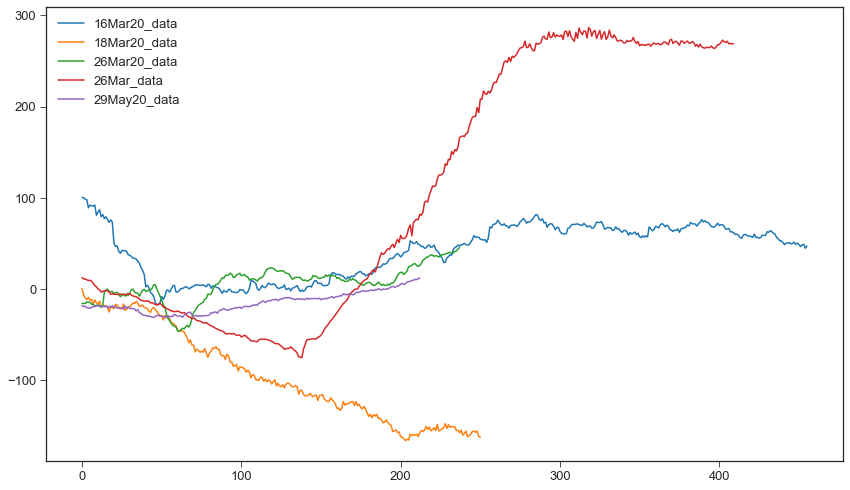

In [5]:
lengths = [len(data_dict[keys[i]]) for i in range(len(keys))]

plt.figure(figsize=(12,7))
for key in keys:
    plot_data = data_dict[key][:,1]
    plot_data = plot_data[np.isnan(plot_data) != True]
    plt.plot(plot_data, label=key)
plt.legend()
plt.tight_layout()
plt.show()

# sklearn time
## XGBoost

In [6]:
X_train, X_test, y_train, y_test = train_test_split(data[:,3:], data[:,1], test_size=0.25)

model = xgb.XGBRegressor()
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

# make predictions for test data
y_pred = model.predict(X_test)

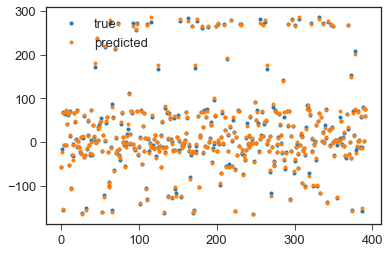

RMS = 3.160


In [7]:
plt.figure()
plt.plot(y_test, '.',label="true")
plt.plot(y_pred, '.', label="predicted")
plt.legend()
plt.show()

rms = np.sqrt(np.sum((y_test-y_pred)**2)/len(y_test))
print(f"RMS = {rms:.3f}")

### New Split Shit

In [8]:
# 50/50 split
X_train, X_test = np.copy(data[ ::2, 3:]), np.copy(data[1::2, 3:])
y_train, y_test = np.copy(data[ ::2, 1 ]), np.copy(data[1::2, 1 ])

model = xgb.XGBRegressor()
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

# make predictions for test data
y_pred = model.predict(X_test)

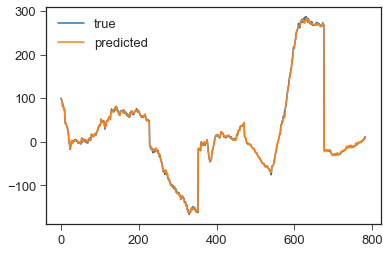

RMS = 2.654


In [9]:
plt.figure()
plt.plot(y_test,label="true")
plt.plot(y_pred, label="predicted")
plt.legend()
plt.show()

rms = np.sqrt(np.sum((y_test-y_pred)**2)/len(y_test))
print(f"RMS = {rms:.3f}")

### Predict 1 timeseries

In [10]:
# Clean and put into data_sort
data_sort = []
for key in keys:
    pre_data = []
    for i in range( len(data_dict[key]) ):
        if ( (data_dict[key][i,3:] != 0.).all() ) & ( (np.isnan(data_dict[key][i, :])!=True).all() ):
            pre_data.append( list(data_dict[key][i,:]) )
    data_sort.append(np.array(pre_data))
print("Shapes of different timeseries:",[i.shape for i in data_sort])

def test_1_timeseries( test_index , scaler=False):
    X_train = np.empty(( 0, data_sort[0].shape[1]-3))
    y_train = np.array([])
    for i in range(len(data_sort)):
        if i!=test_index:
            if scaler:
                scaler = StandardScaler()
                data_scaled = scaler.fit_transform(data_sort[i])
            else:
                data_scaled = data_sort[i]
            X_train = np.append(X_train, data_scaled[:,3:], axis=0)
            y_train = np.append(y_train, data_scaled[:,1])
    if scaler:
        scaler = StandardScaler()
        data_scaled = scaler.fit_transform(data_sort[test_index])
    else: 
        data_scaled = data_sort[test_index]
    X_test = data_scaled[:,3:]
    y_test = data_scaled[:,1]
    return X_train, X_test, y_train, y_test

Shapes of different timeseries: [(456, 28), (247, 28), (238, 28), (407, 28), (211, 28)]


(1348, 25) (211, 25) (1348,) (211,)


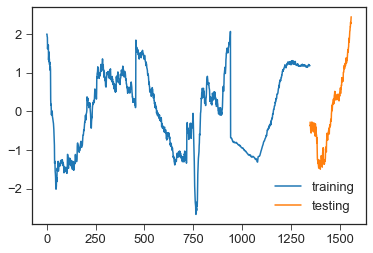

In [11]:
X_train, X_test, y_train, y_test = test_1_timeseries(test_on, scaler=True)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# # Only two features
if only_2_features:
    X_train, X_test = X_train[:, [8-3, 14-3]], X_test[:, [8-3, 14-3]]
    print(X_train.shape, X_test.shape)

# Print figure
plt.figure()
x0 = np.arange(0, len(y_train),1)
x1 = np.arange(len(y_train), len(y_train)+len(y_test),1)
plt.plot(x0, y_train,label="training")
plt.plot(x1, y_test, label="testing")
plt.legend()
plt.show()

### XGboost

In [12]:
# Fit
mlp = xgb.XGBRegressor()
mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)

In [13]:
# Create a model with no hyperparameters
clf_xgb = xgb.XGBRegressor(random_state = 1, n_jobs=4)

# Parameters to search
parameters_RandomSearch = {
    "n_estimators": st.randint(1,20),
    "max_depth": st.randint(1,20),
    "learning_rate": st.uniform()
}

# Number of search rounds
n_iter_search = 100

# Initialize
RandomSearch = RandomizedSearchCV(clf_xgb, 
                                  param_distributions=parameters_RandomSearch, 
                                  n_iter=n_iter_search, 
                                  cv=5,  
                                  return_train_score=True,
                                  random_state=1,
                                  verbose = 1, 
                                  n_jobs = -1,
                                  scoring = 'neg_root_mean_squared_error')

# fit the random search instance
RandomSearch.fit(X_train, y_train)

# Printing best parameters
print("Random Search: \tBest parameters: ", RandomSearch.best_params_, f", Best scores: {RandomSearch.best_score_:.4f}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.6s


Random Search: 	Best parameters:  {'learning_rate': 0.5710085611850925, 'max_depth': 1, 'n_estimators': 14} , Best scores: -0.7726


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    8.7s finished


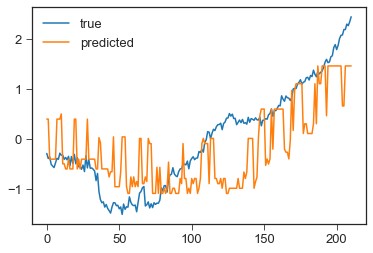

RMS = 0.724


In [14]:
y_pred = RandomSearch.predict(X_test)

plt.figure()
plt.plot(y_test,label="true")
plt.plot(y_pred, label="predicted")
plt.legend()
plt.show()

rms = np.sqrt(np.sum((y_test-y_pred)**2)/len(y_test))
print(f"RMS = {rms:.3f}")

### Bayesian Optimization

In [15]:
from bayes_opt import BayesianOptimization
def xgboost_CrossValidation(num_round, eta, max_depth, data, targets):
    """Decision Tree cross validation.
       Fits a Decision Tree with the given paramaters to the target 
       given data, calculated a CV accuracy score and returns the mean.
       The goal is to find combinations of max_depth, min_samples_leaf 
       that maximize the accuracy
    """
    
    estimator = xgb.XGBRegressor(random_state=42, 
                                  num_round=num_round,
                                  eta=eta,
                                  max_depth=max_depth)
    
    cval = cross_val_score(estimator, data, targets, cv=5)
    
    return cval.mean()

def optimize_xgboost(data, targets, pars, n_iter=5):
    """Apply Bayesian Optimization to Decision Tree parameters."""
    
    def crossval_wrapper(num_round, eta, max_depth, data=data, targets=targets):
        """Wrapper of Decision Tree cross validation. 
           Notice how we ensure max_depth, min_samples_leaf 
           are casted to integer before we pass them along.
        """
        return xgboost_CrossValidation(max_depth=int(max_depth), 
                                       num_round=int(num_round),
                                       eta=eta,
                                       data=data, 
                                       targets=targets)

    optimizer = BayesianOptimization(f=crossval_wrapper, 
                                     pbounds=pars, 
                                     random_state=42, 
                                     verbose=2)
    optimizer.maximize(init_points=4, n_iter=n_iter)

    return optimizer

In [16]:
parameters_BayesianOptimization = {"max_depth": (1, 20), 
                                   "num_round": (1, 20),
                                   "eta": (0,1)
                                  }

BayesianOptimization = optimize_xgboost(data = X_train, 
                                        targets = y_train, 
                                        pars = parameters_BayesianOptimization, 
                                        n_iter=200)
print(BayesianOptimization.max)

|   iter    |  target   |    eta    | max_depth | num_round |
-------------------------------------------------------------
|  1        | -0.8784   |  0.3745   |  19.06    |  14.91    |
|  2        | -0.9716   |  0.5987   |  3.964    |  3.964    |
|  3        | -0.9186   |  0.05808  |  17.46    |  12.42    |
|  4        | -0.6392   |  0.7081   |  1.391    |  19.43    |
|  5        | -0.9565   |  1.0      |  1.0      |  20.0     |
|  6        | -1.202    |  0.0      |  4.988    |  14.87    |
|  7        | -0.9217   |  1.0      |  20.0     |  1.0      |
|  8        | -0.963    |  1.0      |  12.89    |  20.0     |
|  9        | -1.202    |  0.0      |  11.85    |  1.0      |
|  10       | -0.9808   |  1.0      |  11.15    |  8.861    |
|  11       | -1.202    |  0.0      |  6.378    |  20.0     |
|  12       | -0.9565   |  1.0      |  1.0      |  9.884    |
|  13       | -0.9217   |  1.0      |  20.0     |  7.129    |
|  14       | -1.202    |  0.0      |  20.0     |  20.0     |
|  15   

|  80       | -0.8028   |  0.01718  |  10.97    |  15.37    |
|  81       | -0.9163   |  0.1161   |  19.91    |  9.161    |
|  82       | -0.9542   |  0.998    |  8.215    |  19.81    |
|  83       | -1.202    |  0.0      |  8.588    |  15.96    |
|  84       | -0.852    |  0.02494  |  14.51    |  15.62    |
|  85       | -1.007    |  0.07107  |  6.631    |  1.014    |
|  86       | -1.202    |  0.0      |  2.331    |  10.09    |
|  87       | -1.202    |  0.0      |  18.06    |  18.41    |
|  88       | -1.202    |  0.0      |  10.67    |  10.49    |
|  89       | -0.7518   |  0.01491  |  5.098    |  11.33    |
|  90       | -0.9798   |  0.9971   |  9.983    |  1.218    |
|  91       | -0.9738   |  0.9956   |  14.28    |  18.12    |
|  92       | -0.9197   |  1.0      |  17.4     |  10.81    |
|  93       | -0.9808   |  1.0      |  11.29    |  6.452    |
|  94       | -0.9503   |  0.9801   |  13.61    |  1.128    |
|  95       | -1.202    |  0.0      |  12.78    |  13.45    |
|  96   

|  161      | -1.202    |  0.0      |  15.89    |  13.64    |
|  162      | -1.202    |  0.0      |  11.91    |  8.57     |
|  163      | -1.057    |  1.0      |  9.423    |  8.611    |
|  164      | -1.202    |  0.0      |  2.332    |  18.43    |
|  165      | -1.202    |  5.315e-0 |  18.66    |  2.799    |
|  166      | -0.963    |  1.0      |  12.06    |  18.44    |
|  167      | -0.7059   |  0.008585 |  4.564    |  4.828    |
|  168      | -0.9557   |  1.0      |  7.497    |  9.478    |
|  169      | -0.9217   |  1.0      |  20.0     |  5.228    |
|  170      | -1.202    |  0.0      |  13.92    |  11.22    |
|  171      | -0.9273   |  0.05155  |  13.49    |  18.89    |
|  172      | -0.9076   |  0.07699  |  18.73    |  10.76    |
|  173      | -0.9444   |  1.0      |  18.38    |  15.62    |
|  174      | -1.202    |  0.0      |  20.0     |  1.0      |
|  175      | -0.9428   |  1.0      |  13.61    |  16.15    |
|  176      | -0.9444   |  1.0      |  18.5     |  11.95    |
|  177  

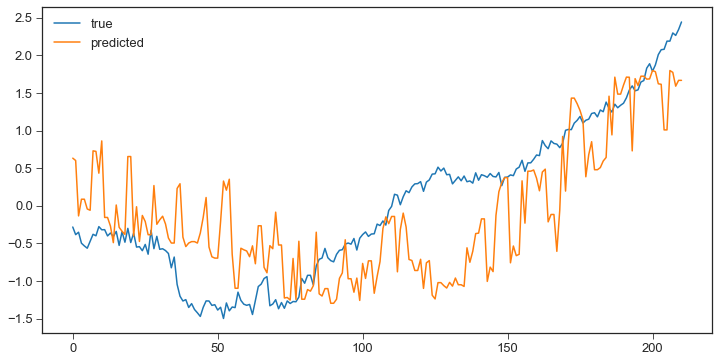

RMS = 0.761


In [17]:
model = xgb.XGBRegressor(eta = BayesianOptimization.max["params"]["eta"],
                          max_depth =int(BayesianOptimization.max["params"]["max_depth"]),
                          num_round = int(BayesianOptimization.max["params"]["num_round"]), 
                          random_state=42)

model.fit(X_train, y_train)

# make predictions for test data
y_pred_xg = model.predict(X_test)#+155

# evaluate predictions
plt.figure(figsize=(12,6))
plt.plot(y_test,label="true")
plt.plot(y_pred_xg, label="predicted")
plt.legend()
plt.show()

rms = np.sqrt(np.sum((y_test-y_pred_xg)**2)/len(y_test))
print(f"RMS = {rms:.3f}")

## NN

In [18]:
# 50/50 split
X_train, X_test = np.copy(data[ ::2, 3:]), np.copy(data[1::2, 3:])
y_train, y_test = np.copy(data[ ::2, 1 ]), np.copy(data[1::2, 1 ])

# Scale in order to 
scaler = StandardScaler()

# Fit only to the training data
scaler.fit(X_train)

# Now apply the transformations to the data:
X_train, X_test = scaler.transform(X_train), scaler.transform(X_test)

In [19]:
mlp = MLPRegressor(hidden_layer_sizes=(15, 14), max_iter=2000)
mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)

C:\Users\jonat\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


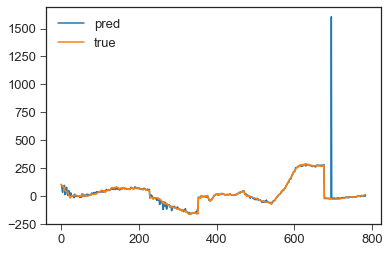

In [20]:
plt.figure()
plt.plot(y_pred,label="pred")
plt.plot(y_test, label="true")
plt.legend()
plt.show()

### CV random search

In [21]:
# Create a model with no hyperparameters
clf_NN = MLPRegressor(learning_rate = 'adaptive', solver='adam', early_stopping=True, max_iter=1000)

class hidden_layer:
    def __init__(self, min_range, max_range, max_layers=2):
        self.max_layers = max_layers
        self.min_range = min_range
        self.max_range = max_range
    
    def rvs(self,random_state):
        self.layers = np.random.randint(1,self.max_layers+1)
        sizes = []
        for i in range(self.layers):
            if i==0:
                sizes.append( np.random.randint(self.min_range, self.max_range) )
            elif sizes[i-1]==1:
                sizes.append( 1 )
            else:
                sizes.append( np.random.randint(self.min_range, sizes[i-1]) )
        return tuple(sizes)

# Parameters to search
parameters_RandomSearch = {
    "activation": ["relu"],#, "logistic", "tanh"],
    "hidden_layer_sizes": hidden_layer(1, 100, max_layers=5),
    "learning_rate_init": st.uniform()
}

# Number of search rounds
n_iter_search = 100

# Initialize
RandomSearch = RandomizedSearchCV(clf_NN, 
                                  param_distributions=parameters_RandomSearch, 
                                  n_iter=n_iter_search, 
                                  cv=5,  
                                  return_train_score=True,
                                  random_state=0,
                                  verbose = 1, 
                                  n_jobs = -1,
                                  scoring = 'neg_root_mean_squared_error')

# fit the random search instance
RandomSearch.fit(X_train, y_train);

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   39.2s finished


In [22]:
# Printing best parameters
print("Random Search: \tBest parameters: ", RandomSearch.best_params_, f", Best scores: {RandomSearch.best_score_:.4f}")

Random Search: 	Best parameters:  {'activation': 'relu', 'hidden_layer_sizes': (58, 51, 28, 19), 'learning_rate_init': 0.6027633760716439} , Best scores: -88.7440


103.91978496875485


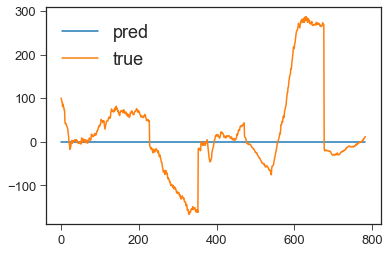

In [23]:
y_pred = RandomSearch.predict(X_test)
rms = np.sqrt(np.sum((y_pred-y_test)**2)/len(y_test))
print(rms)
plt.figure()
plt.plot(y_pred,label="pred")
plt.plot(y_test, label="true")
plt.legend(fontsize=(18))
plt.show()

### Predict one timeseries

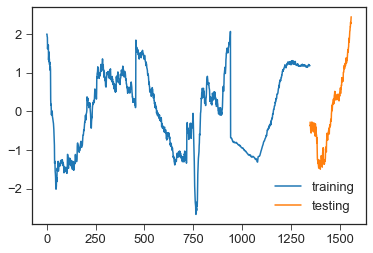

In [24]:
X_train, X_test, y_train, y_test = test_1_timeseries(test_on, scaler=True)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

# Remove to only 2 features
if only_2_features:
    X_train, X_test = X_train[:, [8-3, 14-3]], X_test[:, [8-3, 14-3]]

# Plot
plt.figure()
x0 = np.arange(0, len(y_train),1)
x1 = np.arange(len(y_train), len(y_train)+len(y_test),1)
plt.plot(x0, y_train,label="training")
plt.plot(x1, y_test, label="testing")
plt.legend()
plt.show()

In [25]:
# Fit
mlp = MLPRegressor(hidden_layer_sizes=(15, 14), max_iter=2000)
mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)

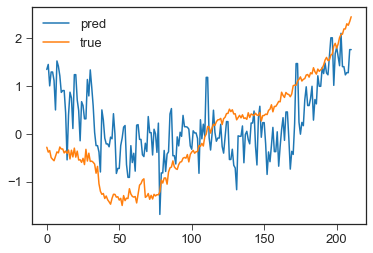

In [26]:
# Plotting
plt.figure()
plt.plot(y_pred,label="pred")
plt.plot(y_test, label="true")
plt.legend()
plt.show()

### CV

In [27]:
# Create a model with no hyperparameters
clf_NN = MLPRegressor(random_state=0, learning_rate = 'adaptive', solver='adam', early_stopping=True)

class hidden_layer:
    def __init__(self, min_range, max_range, max_layers=2):
        self.max_layers = max_layers
        self.min_range = min_range
        self.max_range = max_range
    
    def rvs(self,random_state):
        self.layers = np.random.randint(1,self.max_layers+1)
        sizes = []
        for i in range(self.layers):
            if i==0:
                sizes.append( np.random.randint(self.min_range, self.max_range) )
            elif sizes[i-1]==1:
                sizes.append( 1 )
            else:
                sizes.append( np.random.randint(self.min_range, sizes[i-1]) )
        return tuple(sizes)

# Parameters to search
parameters_RandomSearch = {
    "activation": ["relu"],#, "logistic", "tanh"],
    "hidden_layer_sizes": hidden_layer(1, 100, max_layers=3),
    "learning_rate_init": st.uniform(),
#     "max_iter": st.randint(100,1000)
}

# Number of search rounds
n_iter_search = 100

# Initialize
RandomSearch = RandomizedSearchCV(clf_NN, 
                                  param_distributions=parameters_RandomSearch, 
                                  n_iter=n_iter_search, 
                                  cv=5,  
                                  return_train_score=True,
                                  random_state=0,
                                  verbose = 1, 
                                  n_jobs = -1)

# fit the random search instance
RandomSearch.fit(X_train, y_train);

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 220 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 470 tasks      | elapsed:   44.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   48.1s finished


In [28]:
# Printing best parameters
print("Random Search: \tBest parameters: ", RandomSearch.best_params_, f", Best scores: {RandomSearch.best_score_:.4f}")

Random Search: 	Best parameters:  {'activation': 'relu', 'hidden_layer_sizes': (14, 2), 'learning_rate_init': 0.06022547162926983} , Best scores: -0.7555


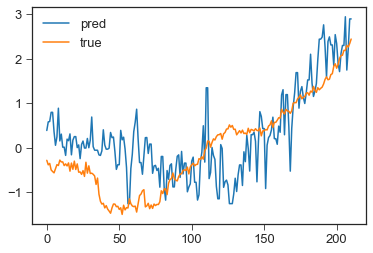

In [29]:
y_pred = RandomSearch.predict(X_test)
rms = np.sqrt(np.sum((y_pred-y_test)**2)/len(y_test))
plt.figure()
plt.plot(y_pred,label="pred")
plt.plot(y_test, label="true")
plt.legend()
plt.show()

## Linear Regression

In [30]:
reg = LinearRegression().fit(X_train, y_train)
y_pred_linear = reg.predict(X_test)

In [31]:
LSTM_res = np.loadtxt("LSTM_predicted_5.txt")

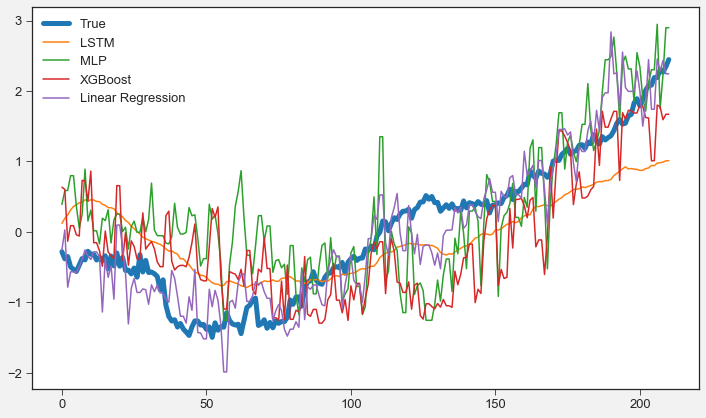

In [32]:
fig = plt.figure(figsize=(10,6))
plt.plot(y_test, label="True", lw=5.)
plt.plot(LSTM_res,label="LSTM")
plt.plot(y_pred, label="MLP")
plt.plot(y_pred_xg, label="XGBoost")
plt.plot(y_pred_linear, label="Linear Regression")
fig.patch.set_facecolor("#f2f2f2")
plt.legend()
plt.tight_layout()
plt.show()

if save:
    fig.savefig(f"figs/Final_result_test_on_{test_on}.png", dpi=500, facecolor=fig.get_facecolor())